In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
data_transform = transforms.Compose([
    # transforms.RandomResizedCrop(500), make 200x200 # normalise values to [0,1], rescaling
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

In [3]:

data_dir = "../data/images/"
train_dataset = datasets.ImageFolder(root=data_dir + "training", transform=data_transform) # make val set
test_dataset = datasets.ImageFolder(root=data_dir + "testing", transform=data_transform)
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
len(testloader)

19

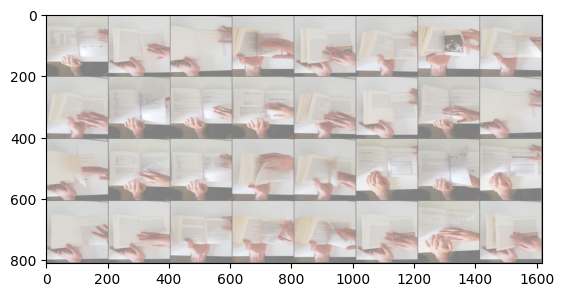

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

In [5]:
inputs, classes = next(iter(trainloader))

In [6]:
inputs.shape

torch.Size([32, 3, 200, 200])

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Input channels = 3, Output channels = 6, Kernel size = 5
        self.pool = nn.MaxPool2d(2, 2)   # Kernel size = 2, Stride = 2
        self.conv2 = nn.Conv2d(6, 16, 5) # Input channels = 6, Output channels = 16, Kernel size = 5
        # Calculated flattened size after conv2 and pooling: 16 * 47 * 47
        self.fc1 = nn.Linear(16 * 47 * 47, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: 98x98x6
        x = self.pool(F.relu(self.conv2(x)))  # Output: 47x47x16
        x = torch.flatten(x, 1)  # Flatten except for batch dimension
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = F.relu(self.fc2(x))  # Fully connected layer
        x = self.fc3(x)          # Output layer
        return x


net = Net()

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [40]:
# net = net.to(device)

In [41]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.05)

In [42]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    losses.append(running_loss / len(trainloader))

print('Finished Training')

ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.

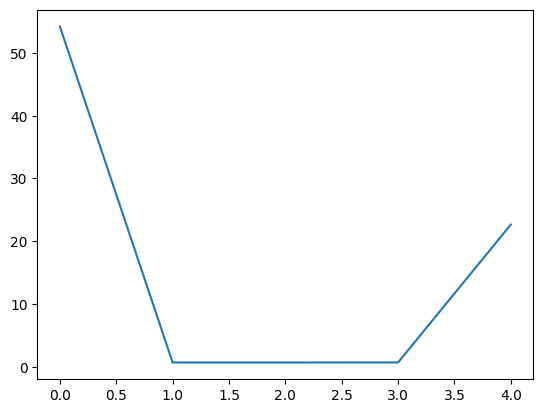

In [22]:
# net.load_state_dict(torch.load('model_weights.pth'))
plt.plot(losses)

In [33]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


net.eval()  # Set the net to evaluation mode

# Variables to store true labels and predictions
all_preds = []
all_labels = []

first_preds = []

# Evaluate the net
with torch.no_grad():  # Disable gradient computation
    count = 0
    for data in testloader:
        count += 1
        inputs, labels = data
        # print(inputs)
        outputs = net(inputs)
        if count == 1:
            first_preds = outputs
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    print(count)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))

19
Accuracy: 0.5142
Precision: 0.2644
Recall: 0.5142
F1 Score: 0.3493
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       290
           1       0.51      1.00      0.68       307

    accuracy                           0.51       597
   macro avg       0.26      0.50      0.34       597
weighted avg       0.26      0.51      0.35       597

[[  0 290]
 [  0 307]]


/nix/store/5325zrc2d172vhqf8paghcgpksr66g2m-python3-3.11.9-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/nix/store/5325zrc2d172vhqf8paghcgpksr66g2m-python3-3.11.9-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/nix/store/5325zrc2d172vhqf8paghcgpksr66g2m-python3-3.11.9-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

In [35]:
len(first_preds)

32

In [27]:
dataiter = iter(testloader)
images, labels = next(dataiter)
labels = labels.view(-1,1).float()

In [28]:
net(images)

tensor([[-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767],
        [-0.0875,  0.0767]], grad_fn=<AddmmBackward0>)

In [ ]:
# Accuracy: 0.9615
# Precision: 0.9615
# Recall: 0.9615
# F1 Score: 0.9615
#               precision    recall  f1-score   support

#            0       0.96      0.96      0.96       290
#            1       0.96      0.96      0.96       307

#     accuracy                           0.96       597
#    macro avg       0.96      0.96      0.96       597
# weighted avg       0.96      0.96      0.96       597

# [[278  12]
#  [ 11 296]]